# Example GSE123139 co-expression

### Dataset
This is an demonstration of co-expression analysis with Normalisr within dysfunctional T cells in human melanoma scRNA-seq. This includes iterative removal of top GO pathways. Only a subset of cells were extracted from GSE123139 dataset for this demonstration. You can change it to all the cells by following the guideline in example README.

**Warning**: You will only get the actual results with the **full dataset** of all cells. This example is intended as a demonstration of use for Normalisr, than an exact reproduction of our results in the manuscript.

### Usage
You can get the help of any function by typing ?func in jupyter notebook. For example, the line below shows documentation for function 'open'.

`?open`

To get help for Normalisr, try a specific function such as

`import normalisr.normalisr as norm
?norm.coex`

In [1]:
import numpy as np
import normalisr.normalisr as norm
from os.path import join as pjoin
import matplotlib.pyplot as plt
from scipy.io import mmread
import networkx as nx
import pandas as pd

diri='../data/coex'

### Optional extra logging

In [2]:
import logging
# logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)

### Load data

In [3]:
dt0=mmread(pjoin(diri,'0_read.mtx.gz')).astype(int).toarray()
dc=np.loadtxt(pjoin(diri,'0_cov.tsv.gz'),delimiter='\t',dtype=int)
with open(pjoin(diri,'0_gene.txt'),'r') as f:
	namet=np.array([x.strip() for x in f.readlines()])
with open(pjoin(diri,'0_cell.txt'),'r') as f:
	names=np.array([x.strip() for x in f.readlines()])
with open(pjoin(diri,'0_cov.txt'),'r') as f:
	namec=np.array([x.strip() for x in f.readlines()])
nc,ns,nt=[len(x) for x in [namec,names,namet]]
assert dt0.shape==(nt,ns) and dc.shape==(nc,ns)

### Initial QC for low read cell and gene removal

In [4]:
select=norm.qc_reads(dt0,0,500,0.02,500,100,0)
print('Genes passed QC: {}/{}'.format(len(select[0]),nt))
print('Cells passed QC: {}/{}'.format(len(select[1]),ns))

dt0=dt0[select[0]][:,select[1]].copy()
dc=dc[:,select[1]].copy()
namet=namet[select[0]]
names=names[select[1]]
ns,nt=[len(x) for x in [names,namet]]
assert dt0.shape==(nt,ns) and dc.shape==(nc,ns)

INFO:root:Removed 26426/28031 genes and 20/5099 cells in QC.


Genes passed QC: 1605/28031
Cells passed QC: 5079/5099


### Compute Bayesian logCPM and cellular summary covariates

In [5]:
dt,_,_,dc2=norm.lcpm(dt0)
dc=np.concatenate([dc,dc2],axis=0)

### Normalize covariates and add constant-1 covariate

In [6]:
dc=norm.normcov(dc)

### Compute variance normalization factors for each gene and each cell

In [7]:
sf=norm.scaling_factor(dt0)
weight=norm.compute_var(dt,dc)

### Detect very-low-variance cell outliers

In [8]:
select=norm.qc_outlier(weight)

INFO:root:Removed 16/5079 cells due to variance outlier


### Remove very-low-variance cell outliers

In [9]:
print('Cells passed outlier QC: {}/{}'.format(select.sum(),ns))
dt0=dt0[:,select].copy()
dt=dt[:,select].copy()
dc=dc[:,select].copy()
weight=weight[select]
names=names[select]
ns=len(names)

Cells passed outlier QC: 5063/5079


### Normalize gene expression at mean and variance levels and covariates at variance level

In [10]:
dt,dc=norm.normvar(dt,dc,weight,sf)

### Compute co-expression network from 0 to 5 removals of top GO pathways

In [11]:
#Maximum number of iterations of GO pathway removal
lvmax=5
#Q-value cutoff when binarizing network
qcut=1E-8
#GO DAG file, downloadable from http://geneontology.org/docs/download-ontology/
go_file='../data/go/go-basic.obo'
#GO annotation file, downloadable from http://current.geneontology.org/products/pages/downloads.html
goa_file='../data/go/goa-human.gaf'
#Gene name conversion rule from your gene ID system to GO annotation file's ID system
#Format: (Your ID system, GO annotation file's ID system, species)
#Names of gene ID systems can be found at https://docs.mygene.info/en/latest/doc/data.html
conversion=("symbol,alias","uniprot.Swiss-Prot","human")

dc2=dc.copy()
coex=[]
for xi in range(lvmax+1):
	#Compute co-expression network of P-values and Pearson R
	coex1=norm.coex(dt,dc2)
	#Binarize co-expression network
	coex2=norm.binnet(coex1[0],qcut)
	#Get strongest GO pathway 
	go=norm.gotop(coex2,namet,go_file,goa_file,conversion=conversion)
	#Store this iteration of results
	coex.append((coex1,coex2,go,dc2))
	#Prepare GO covariate for next iteration
	dc2=norm.pccovt(dt,dc2,namet,go[3])


INFO:root:Using automatic batch size: 500


querying 1-1000...done.
querying 1001-1605...done.
Finished.
220 input query terms found dup hits:
	[('SNORA67', 2), ('HCP5', 6), ('RPS26P3', 3), ('SLA', 2), ('CD97', 2), ('RFC1', 2), ('RPL39P3', 2), 
135 input query terms found no hit:
	['RP11-543P15.1', 'RP1-102E24.1', 'RP11-543B16.1', 'RP11-201K10.3', 'CTD-2013N17.1', 'AD000671.6', '
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
../data/go/go-basic.obo: fmt(1.2) rel(2020-08-11) 47,277 GO Terms
HMS:0:00:11.865087 589,772 annotations READ: ../data/go/goa-human.gaf 
17727 IDs in loaded association branch, BP

Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 95%  1,267 of  1,327 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 69 IDs ...100%     69 of     69 study items found in association
100%     69 of     69 study items found in population(1327)
Calculating 7,4

INFO:root:Using automatic batch size: 500


querying 1-1000...done.
querying 1001-1605...done.
Finished.
220 input query terms found dup hits:
	[('SNORA67', 2), ('HCP5', 6), ('RPS26P3', 3), ('SLA', 2), ('CD97', 2), ('RFC1', 2), ('RPL39P3', 2), 
135 input query terms found no hit:
	['RP11-543P15.1', 'RP1-102E24.1', 'RP11-543B16.1', 'RP11-201K10.3', 'CTD-2013N17.1', 'AD000671.6', '
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
../data/go/go-basic.obo: fmt(1.2) rel(2020-08-11) 47,277 GO Terms
HMS:0:00:12.807335 589,772 annotations READ: ../data/go/goa-human.gaf 
17727 IDs in loaded association branch, BP

Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 95%  1,267 of  1,327 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 61 IDs ... 98%     60 of     61 study items found in association
100%     61 of     61 study items found in population(1327)
Calculating 7,4

INFO:root:Using automatic batch size: 500


querying 1-1000...done.
querying 1001-1605...done.
Finished.
220 input query terms found dup hits:
	[('SNORA67', 2), ('HCP5', 6), ('RPS26P3', 3), ('SLA', 2), ('CD97', 2), ('RFC1', 2), ('RPL39P3', 2), 
135 input query terms found no hit:
	['RP11-543P15.1', 'RP1-102E24.1', 'RP11-543B16.1', 'RP11-201K10.3', 'CTD-2013N17.1', 'AD000671.6', '
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
../data/go/go-basic.obo: fmt(1.2) rel(2020-08-11) 47,277 GO Terms
HMS:0:00:12.315661 589,772 annotations READ: ../data/go/goa-human.gaf 
17727 IDs in loaded association branch, BP

Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 95%  1,267 of  1,327 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 52 IDs ... 98%     51 of     52 study items found in association
100%     52 of     52 study items found in population(1327)
Calculating 7,4

INFO:root:Using automatic batch size: 500


querying 1-1000...done.
querying 1001-1605...done.
Finished.
220 input query terms found dup hits:
	[('SNORA67', 2), ('HCP5', 6), ('RPS26P3', 3), ('SLA', 2), ('CD97', 2), ('RFC1', 2), ('RPL39P3', 2), 
135 input query terms found no hit:
	['RP11-543P15.1', 'RP1-102E24.1', 'RP11-543B16.1', 'RP11-201K10.3', 'CTD-2013N17.1', 'AD000671.6', '
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
../data/go/go-basic.obo: fmt(1.2) rel(2020-08-11) 47,277 GO Terms
HMS:0:00:11.773526 589,772 annotations READ: ../data/go/goa-human.gaf 
17727 IDs in loaded association branch, BP

Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 95%  1,267 of  1,327 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 30 IDs ... 97%     29 of     30 study items found in association
100%     30 of     30 study items found in population(1327)
Calculating 7,4

INFO:root:Using automatic batch size: 500


querying 1-1000...done.
querying 1001-1605...done.
Finished.
220 input query terms found dup hits:
	[('SNORA67', 2), ('HCP5', 6), ('RPS26P3', 3), ('SLA', 2), ('CD97', 2), ('RFC1', 2), ('RPL39P3', 2), 
135 input query terms found no hit:
	['RP11-543P15.1', 'RP1-102E24.1', 'RP11-543B16.1', 'RP11-201K10.3', 'CTD-2013N17.1', 'AD000671.6', '
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
../data/go/go-basic.obo: fmt(1.2) rel(2020-08-11) 47,277 GO Terms
HMS:0:00:11.897470 589,772 annotations READ: ../data/go/goa-human.gaf 
17727 IDs in loaded association branch, BP

Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 95%  1,267 of  1,327 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 31 IDs ... 97%     30 of     31 study items found in association
100%     31 of     31 study items found in population(1327)
Calculating 7,4

INFO:root:Using automatic batch size: 500


querying 1-1000...done.
querying 1001-1605...done.
Finished.
220 input query terms found dup hits:
	[('SNORA67', 2), ('HCP5', 6), ('RPS26P3', 3), ('SLA', 2), ('CD97', 2), ('RFC1', 2), ('RPL39P3', 2), 
135 input query terms found no hit:
	['RP11-543P15.1', 'RP1-102E24.1', 'RP11-543B16.1', 'RP11-201K10.3', 'CTD-2013N17.1', 'AD000671.6', '
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
../data/go/go-basic.obo: fmt(1.2) rel(2020-08-11) 47,277 GO Terms
HMS:0:00:12.905888 589,772 annotations READ: ../data/go/goa-human.gaf 
17727 IDs in loaded association branch, BP

Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 95%  1,267 of  1,327 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 48 IDs ... 96%     46 of     48 study items found in association
100%     48 of     48 study items found in population(1327)
Calculating 7,4

## Visalization
### Top GOs without removal through GO covariate

In [12]:
coex[0][2][1].head(3)

name  depth  p_uncorrected  \
0                                viral transcription      4   4.496185e-18   
1  SRP-dependent cotranslational protein targetin...     12   2.129647e-17   
2  nuclear-transcribed mRNA catabolic process, no...     10   6.395377e-17   

   p_bonferroni  odds_ratio ratio_in_study ratio_in_pop          GO  \
0  3.365844e-14    6.832380          27/69      76/1327  GO:0019083   
1  1.594254e-13    6.490761          27/69      80/1327  GO:0006614   
2  4.787579e-13    6.256155          27/69      83/1327  GO:0000184   

                                         study_items  
0  RPLP1,RPLP2,RPS2,RPS12,RPL13,RPS19,RPL13A,RPL2...  
1  RPLP1,RPLP2,RPS2,RPS12,RPL13,RPS19,RPL13A,RPL2...  
2  RPLP1,RPLP2,RPS2,RPS12,RPL13,RPS19,RPL13A,RPL2...

### Top GOs after 1 removal through GO covariate

In [13]:
coex[1][2][1].head(3)

name  depth  p_uncorrected  p_bonferroni  \
0            response to other organism      4   5.750533e-07      0.004305   
1           response to biotic stimulus      2   8.868708e-07      0.006639   
2  response to external biotic stimulus      3   2.584822e-06      0.019350   

   odds_ratio ratio_in_study ratio_in_pop          GO  \
0    3.387933          19/61     122/1327  GO:0051707   
1    3.025404          21/61     151/1327  GO:0009607   
2    2.959741          20/61     147/1327  GO:0043207   

                                         study_items  
0  HLA-B,HLA-DRB1,GAPDH,ISG15,HMGN2,TUBB,HMGB1,IF...  
1  HLA-B,HLA-DRB1,GAPDH,ISG15,HMGN2,TUBB,VIM,HMGB...  
2  HLA-B,HLA-DRB1,GAPDH,ISG15,HMGN2,TUBB,VIM,HMGB...

### Top GOs after 2 removals through GO covariate

In [14]:
coex[2][2][1].head(3)

name  depth  p_uncorrected  \
0          negative regulation of biological process      3   1.860471e-09   
1  negative regulation of execution phase of apop...      8   7.154954e-08   
2                         response to other organism      4   1.930072e-07   

   p_bonferroni  odds_ratio ratio_in_study ratio_in_pop          GO  \
0      0.000014    1.852202          45/52     620/1327  GO:0048519   
1      0.000536   19.139423           6/52       8/1327  GO:1900118   
2      0.001445    3.765132          18/52     122/1327  GO:0051707   

                                         study_items  
0  CXCL13,HLA-B,HLA-DRB1,MT2A,CD74,ISG15,PFN1,IFI...  
1  MTRNR2L1,MTRNR2L2,MTRNR2L6,MTRNR2L8,MTRNR2L9,M...  
2  CXCL13,HLA-B,HLA-DRB1,ISG15,TUBB,IFI6,GZMB,GZM...

### Networks

Co-expression with 0 GO covariates removed.
Number of nodes in full network: 502
Number of edges in full network: 1551
Number of nodes in major connected component: 408
Number of edges in major connected component: 1470


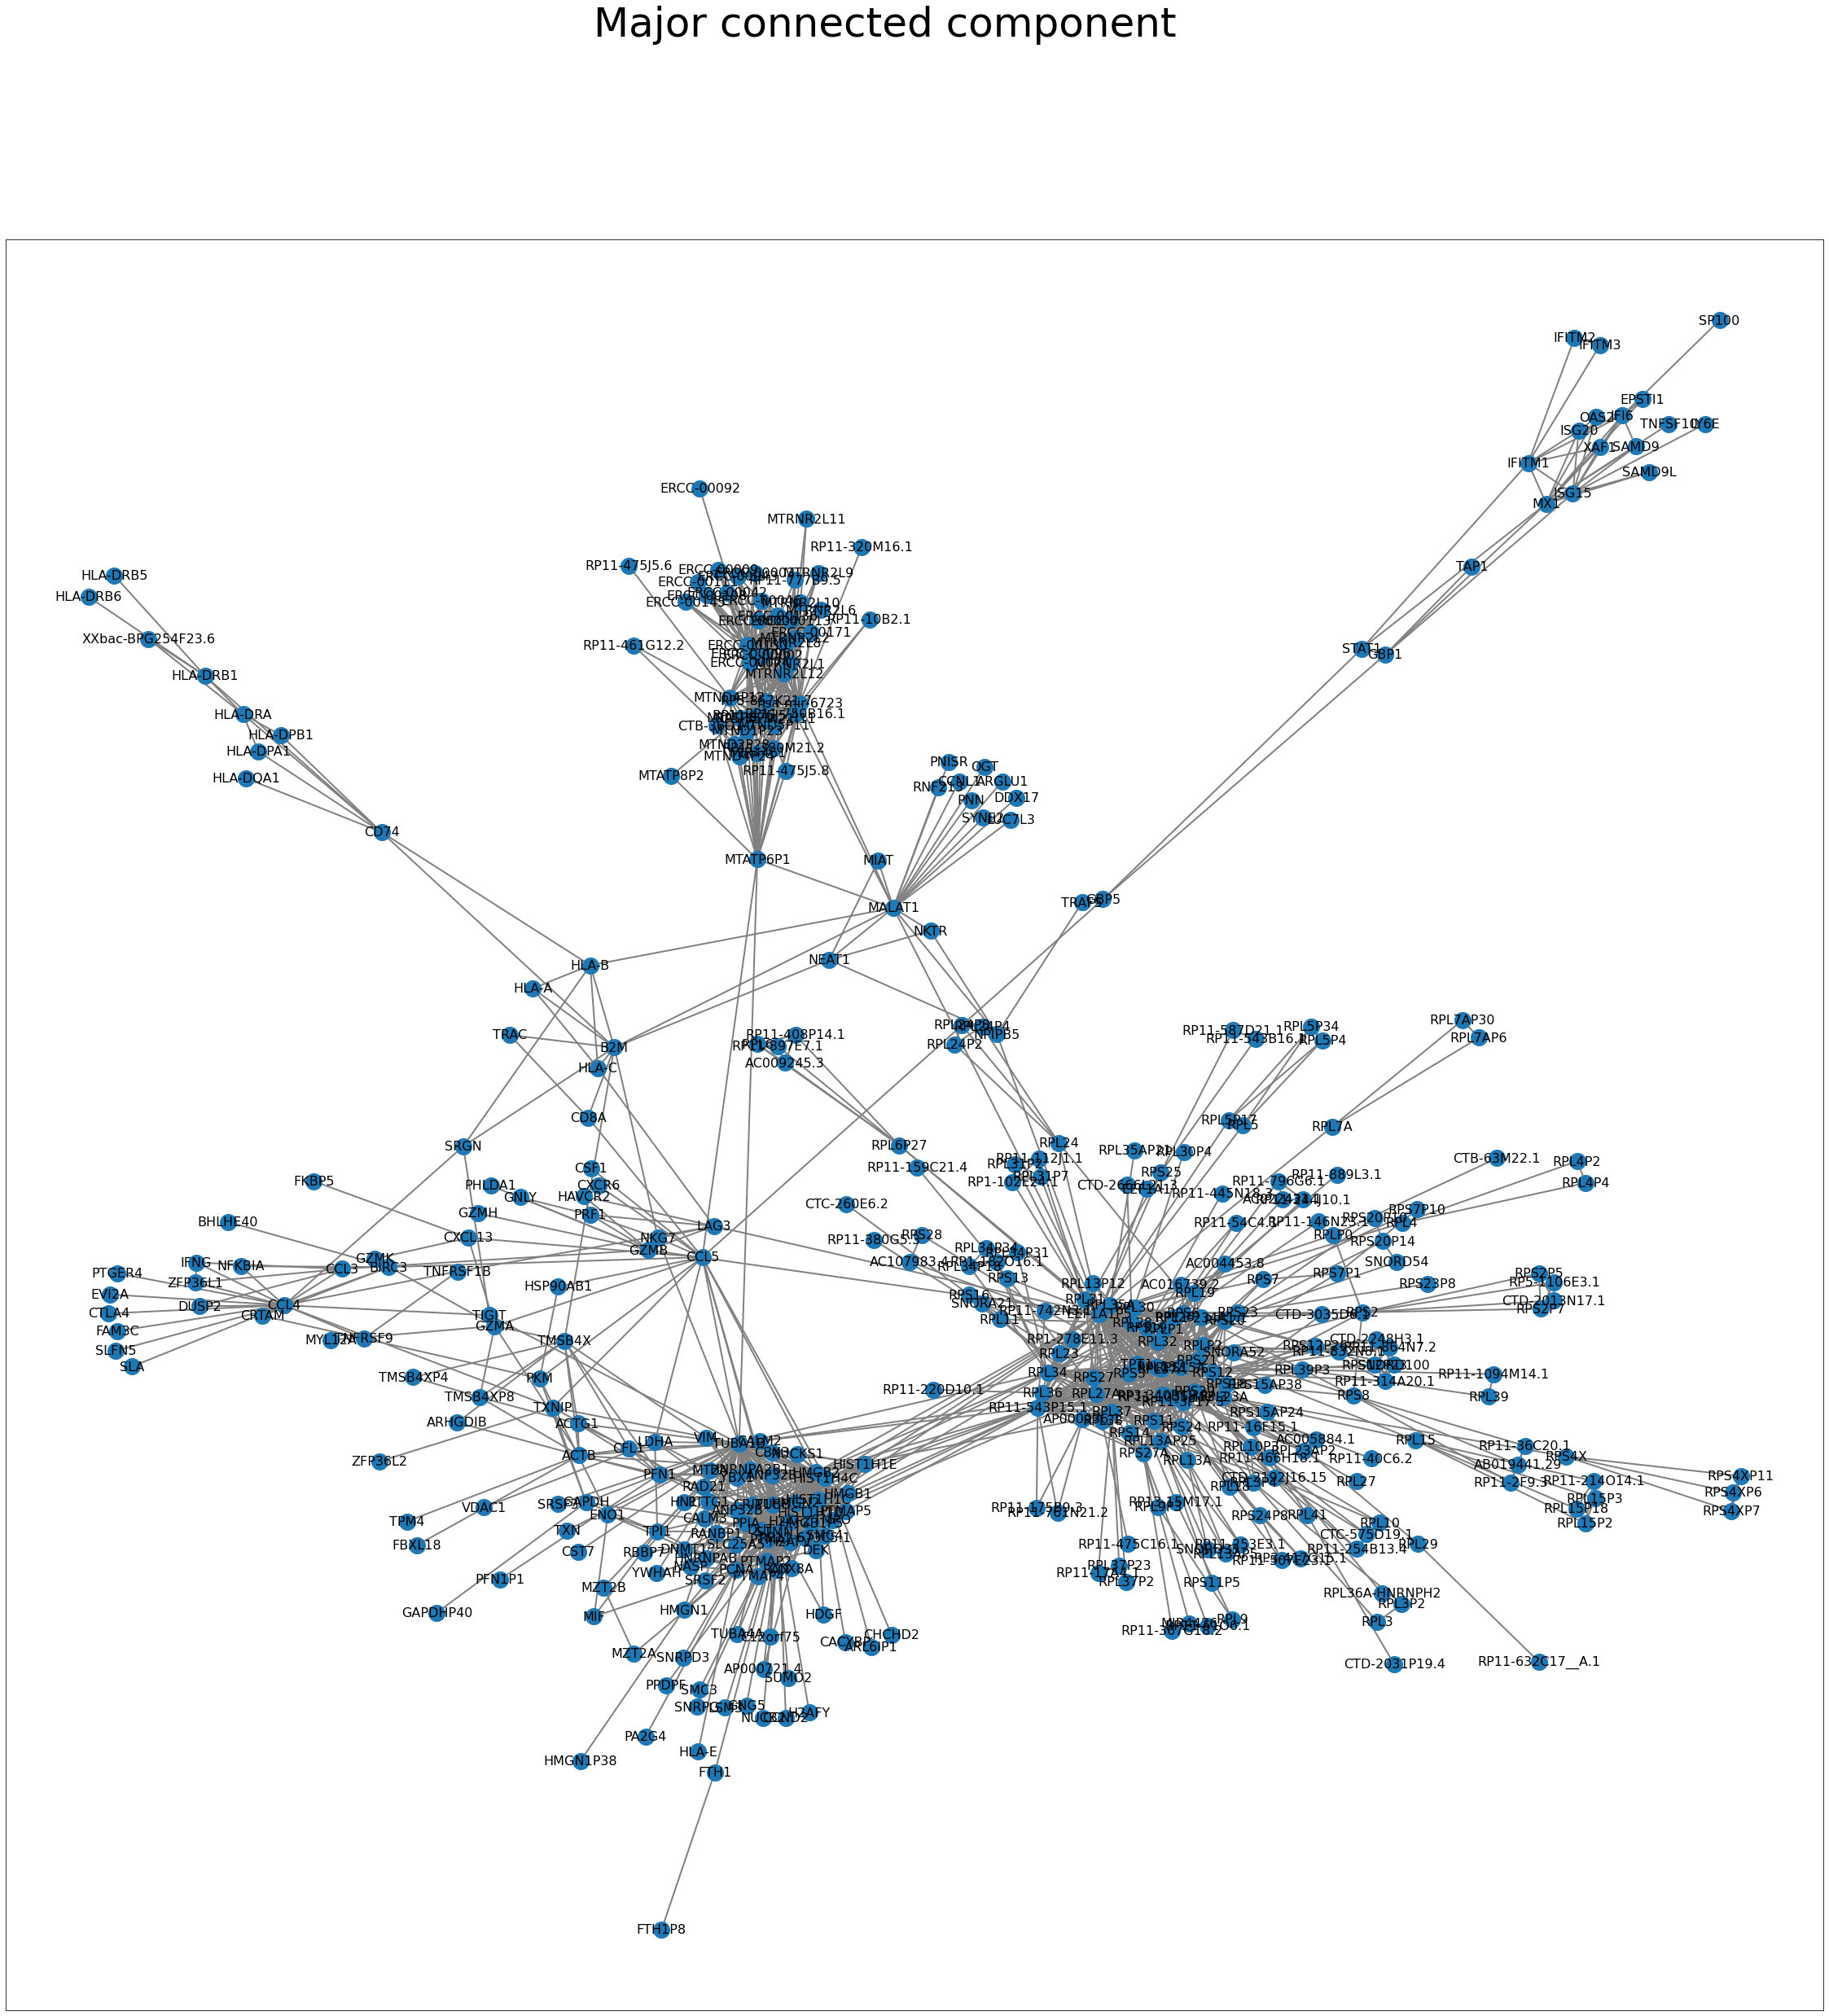

Co-expression with 1 GO covariates removed.
Number of nodes in full network: 482
Number of edges in full network: 1087
Number of nodes in major connected component: 227
Number of edges in major connected component: 792


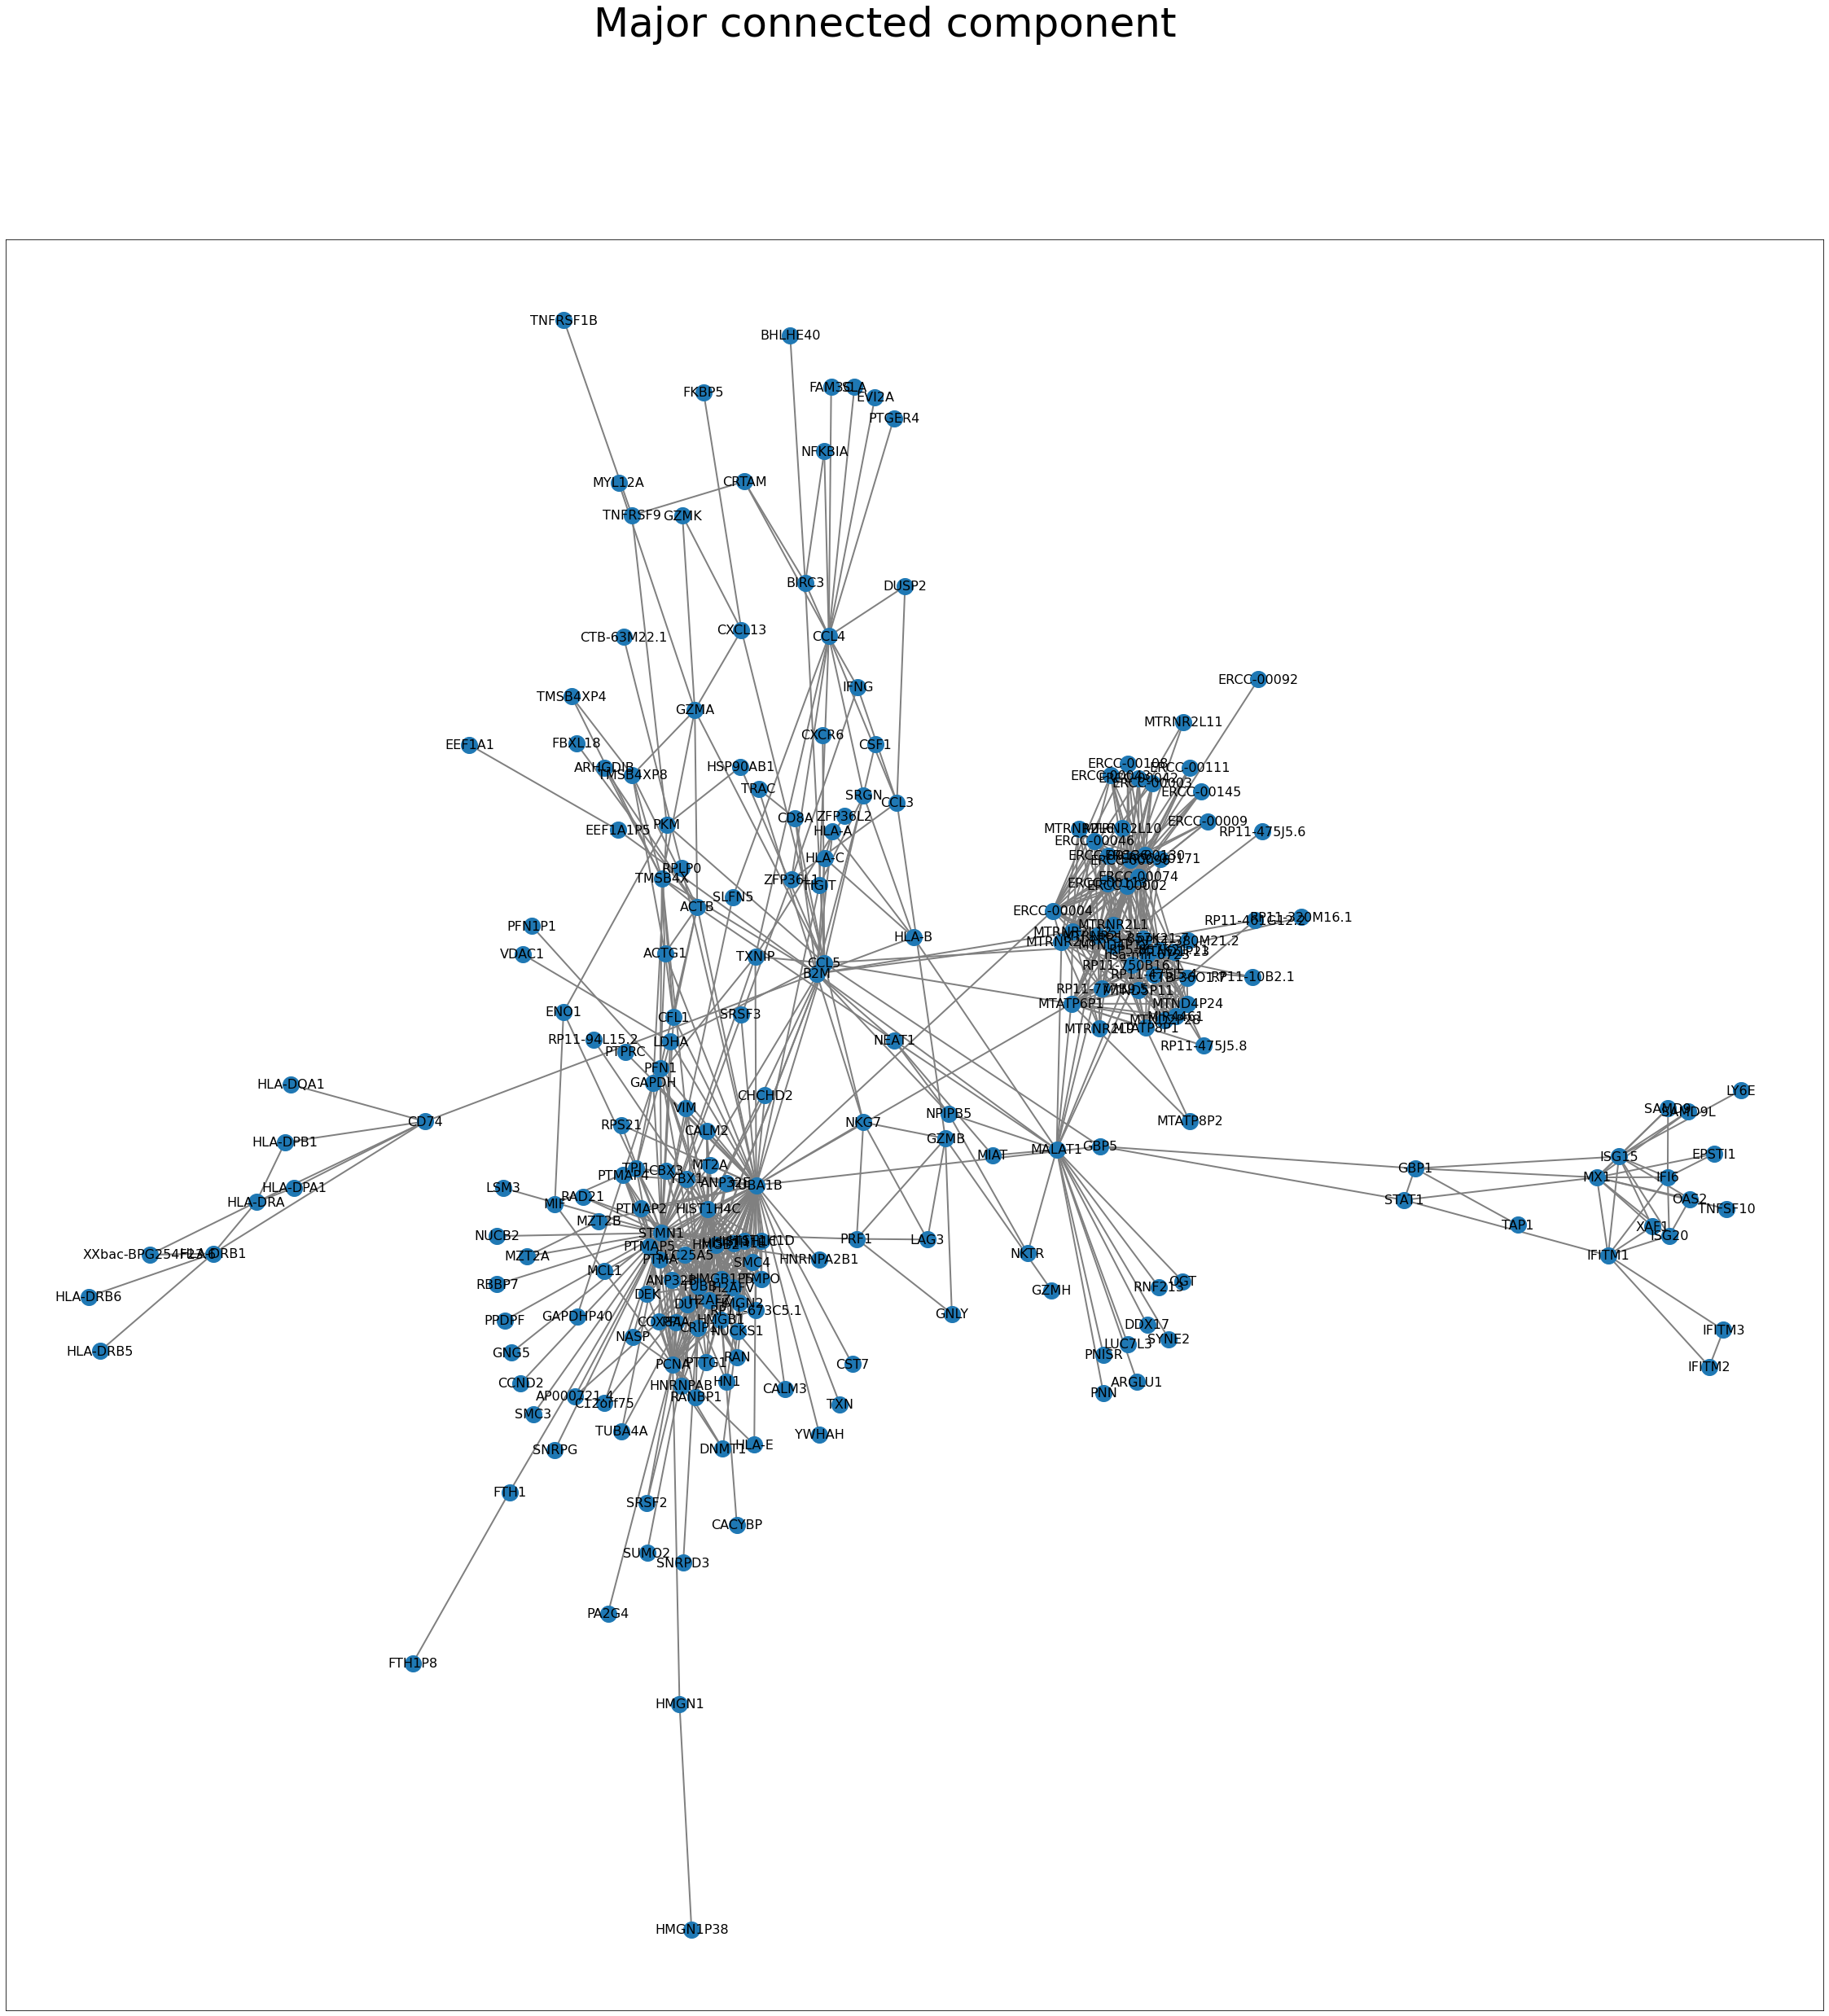

Co-expression with 2 GO covariates removed.
Number of nodes in full network: 431
Number of edges in full network: 808
Number of nodes in major connected component: 164
Number of edges in major connected component: 503


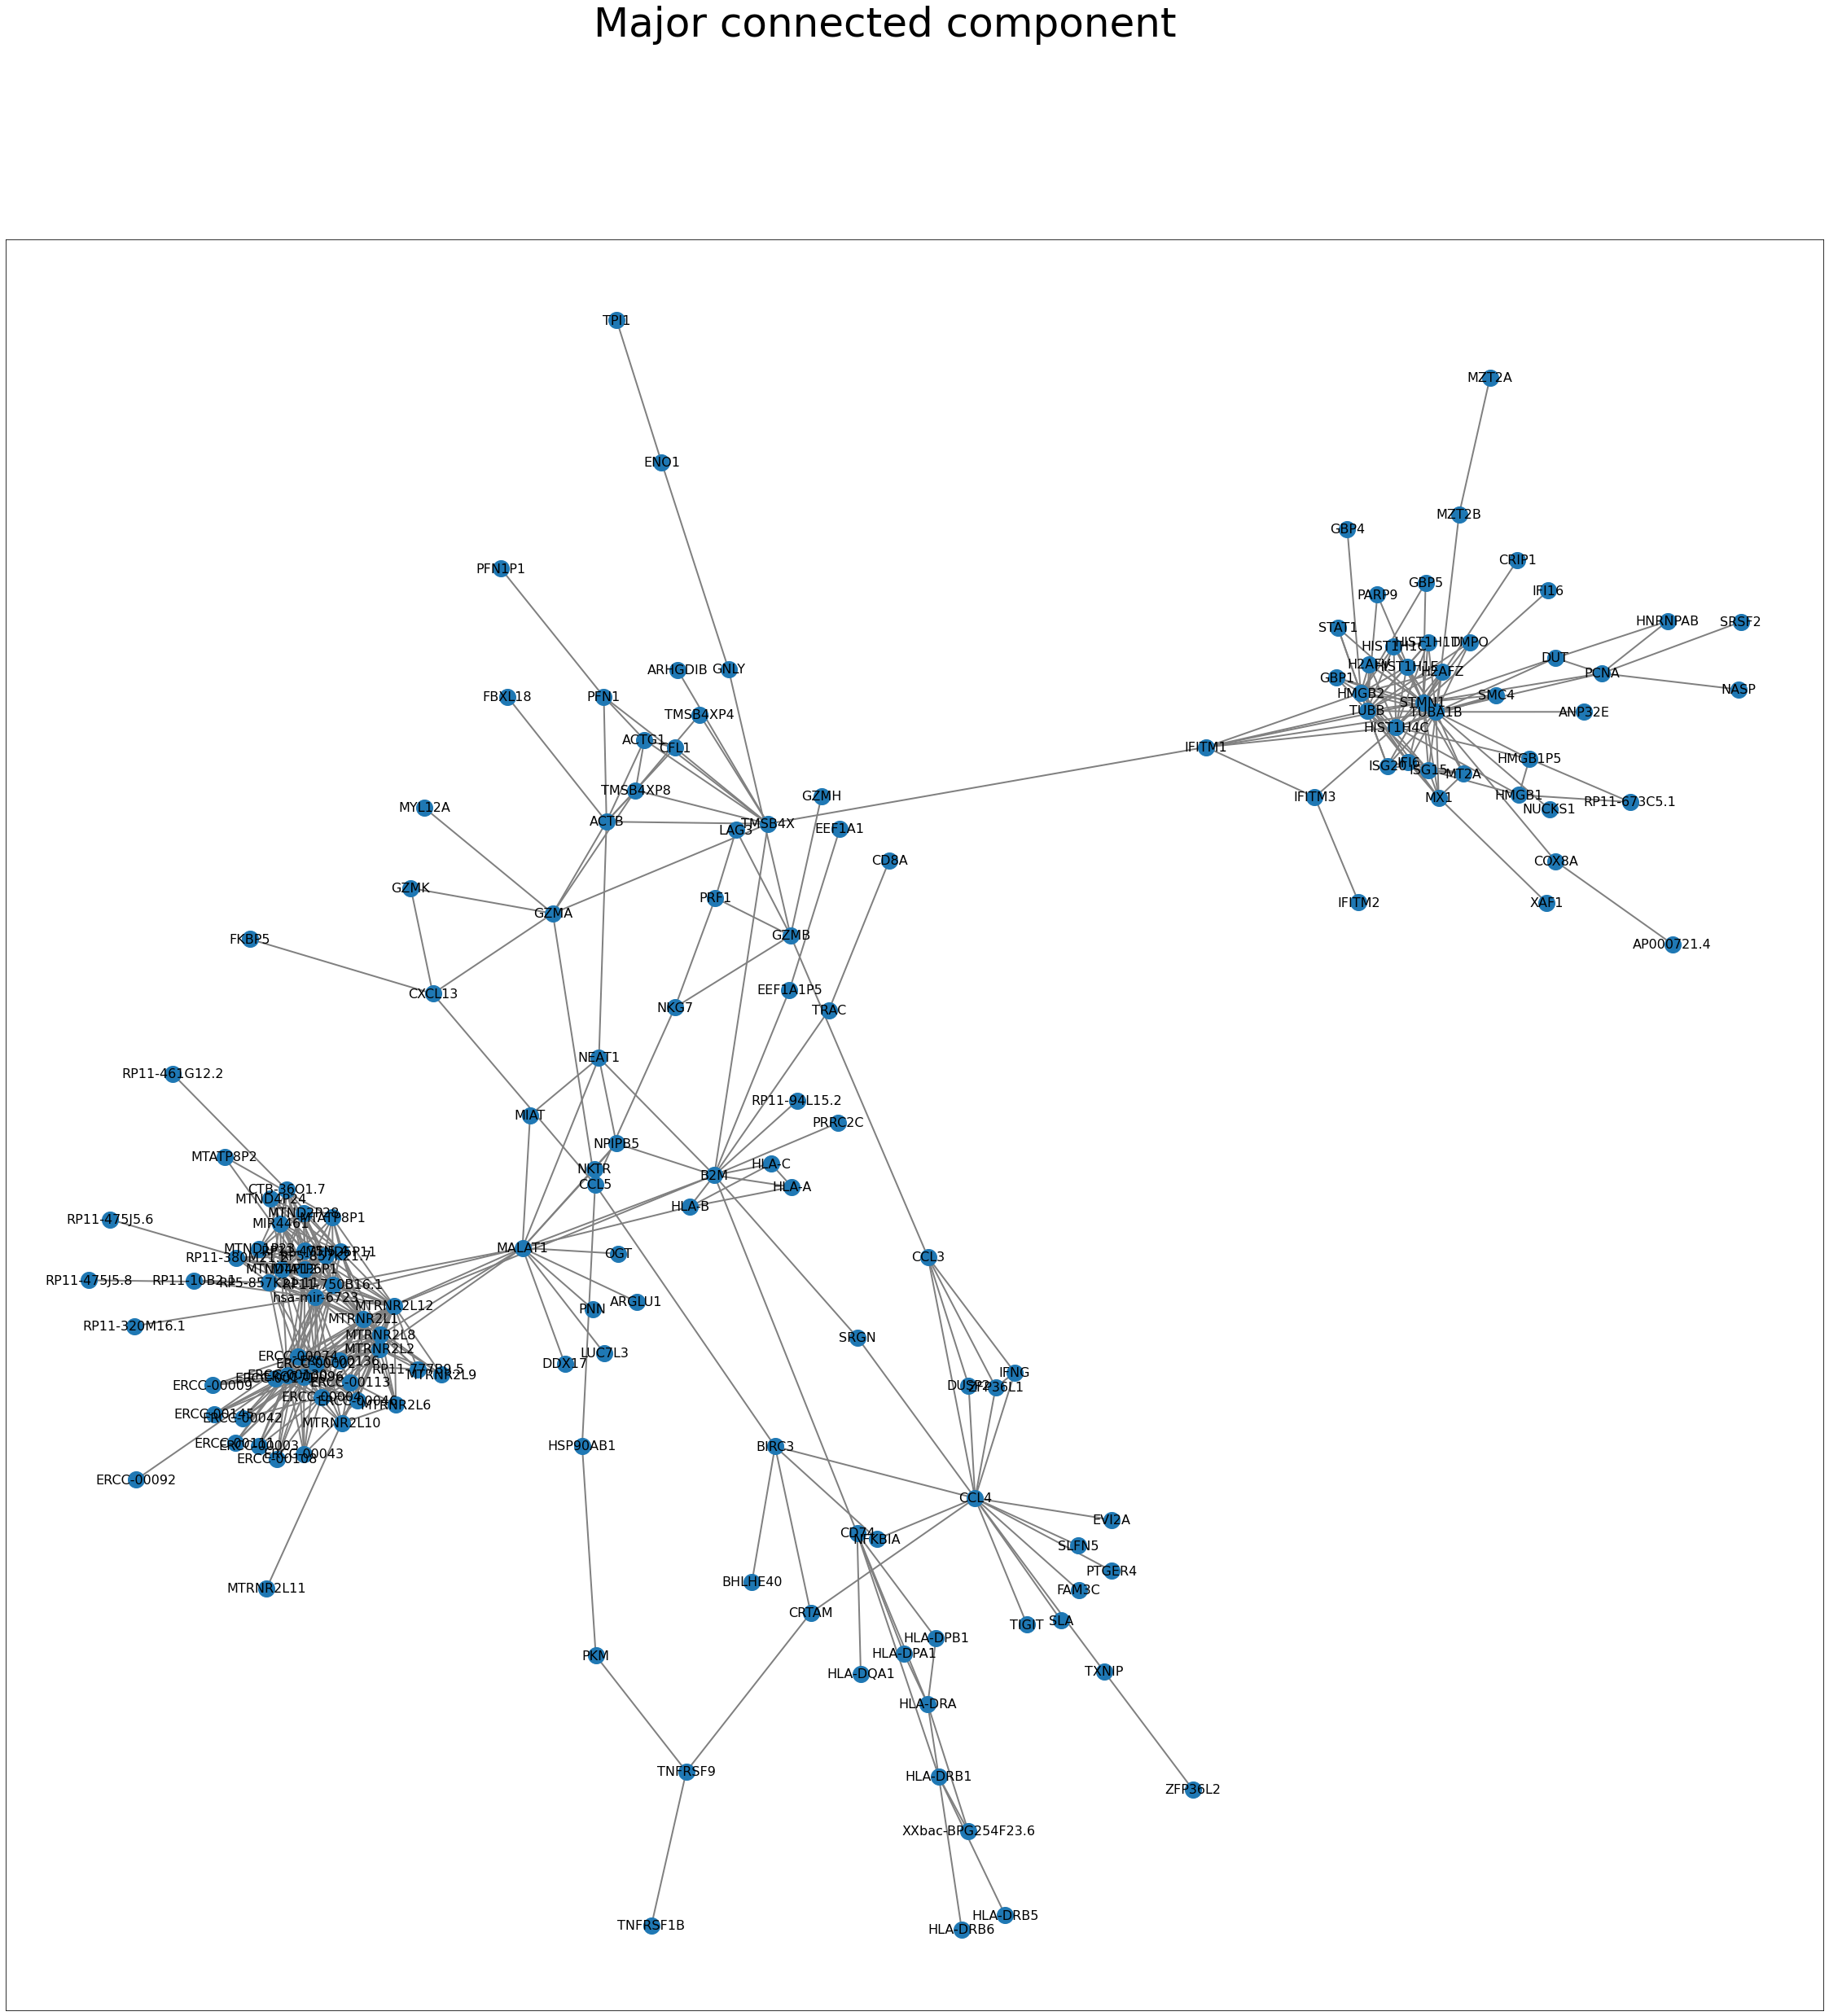

Co-expression with 3 GO covariates removed.
Number of nodes in full network: 402
Number of edges in full network: 681
Number of nodes in major connected component: 111
Number of edges in major connected component: 355


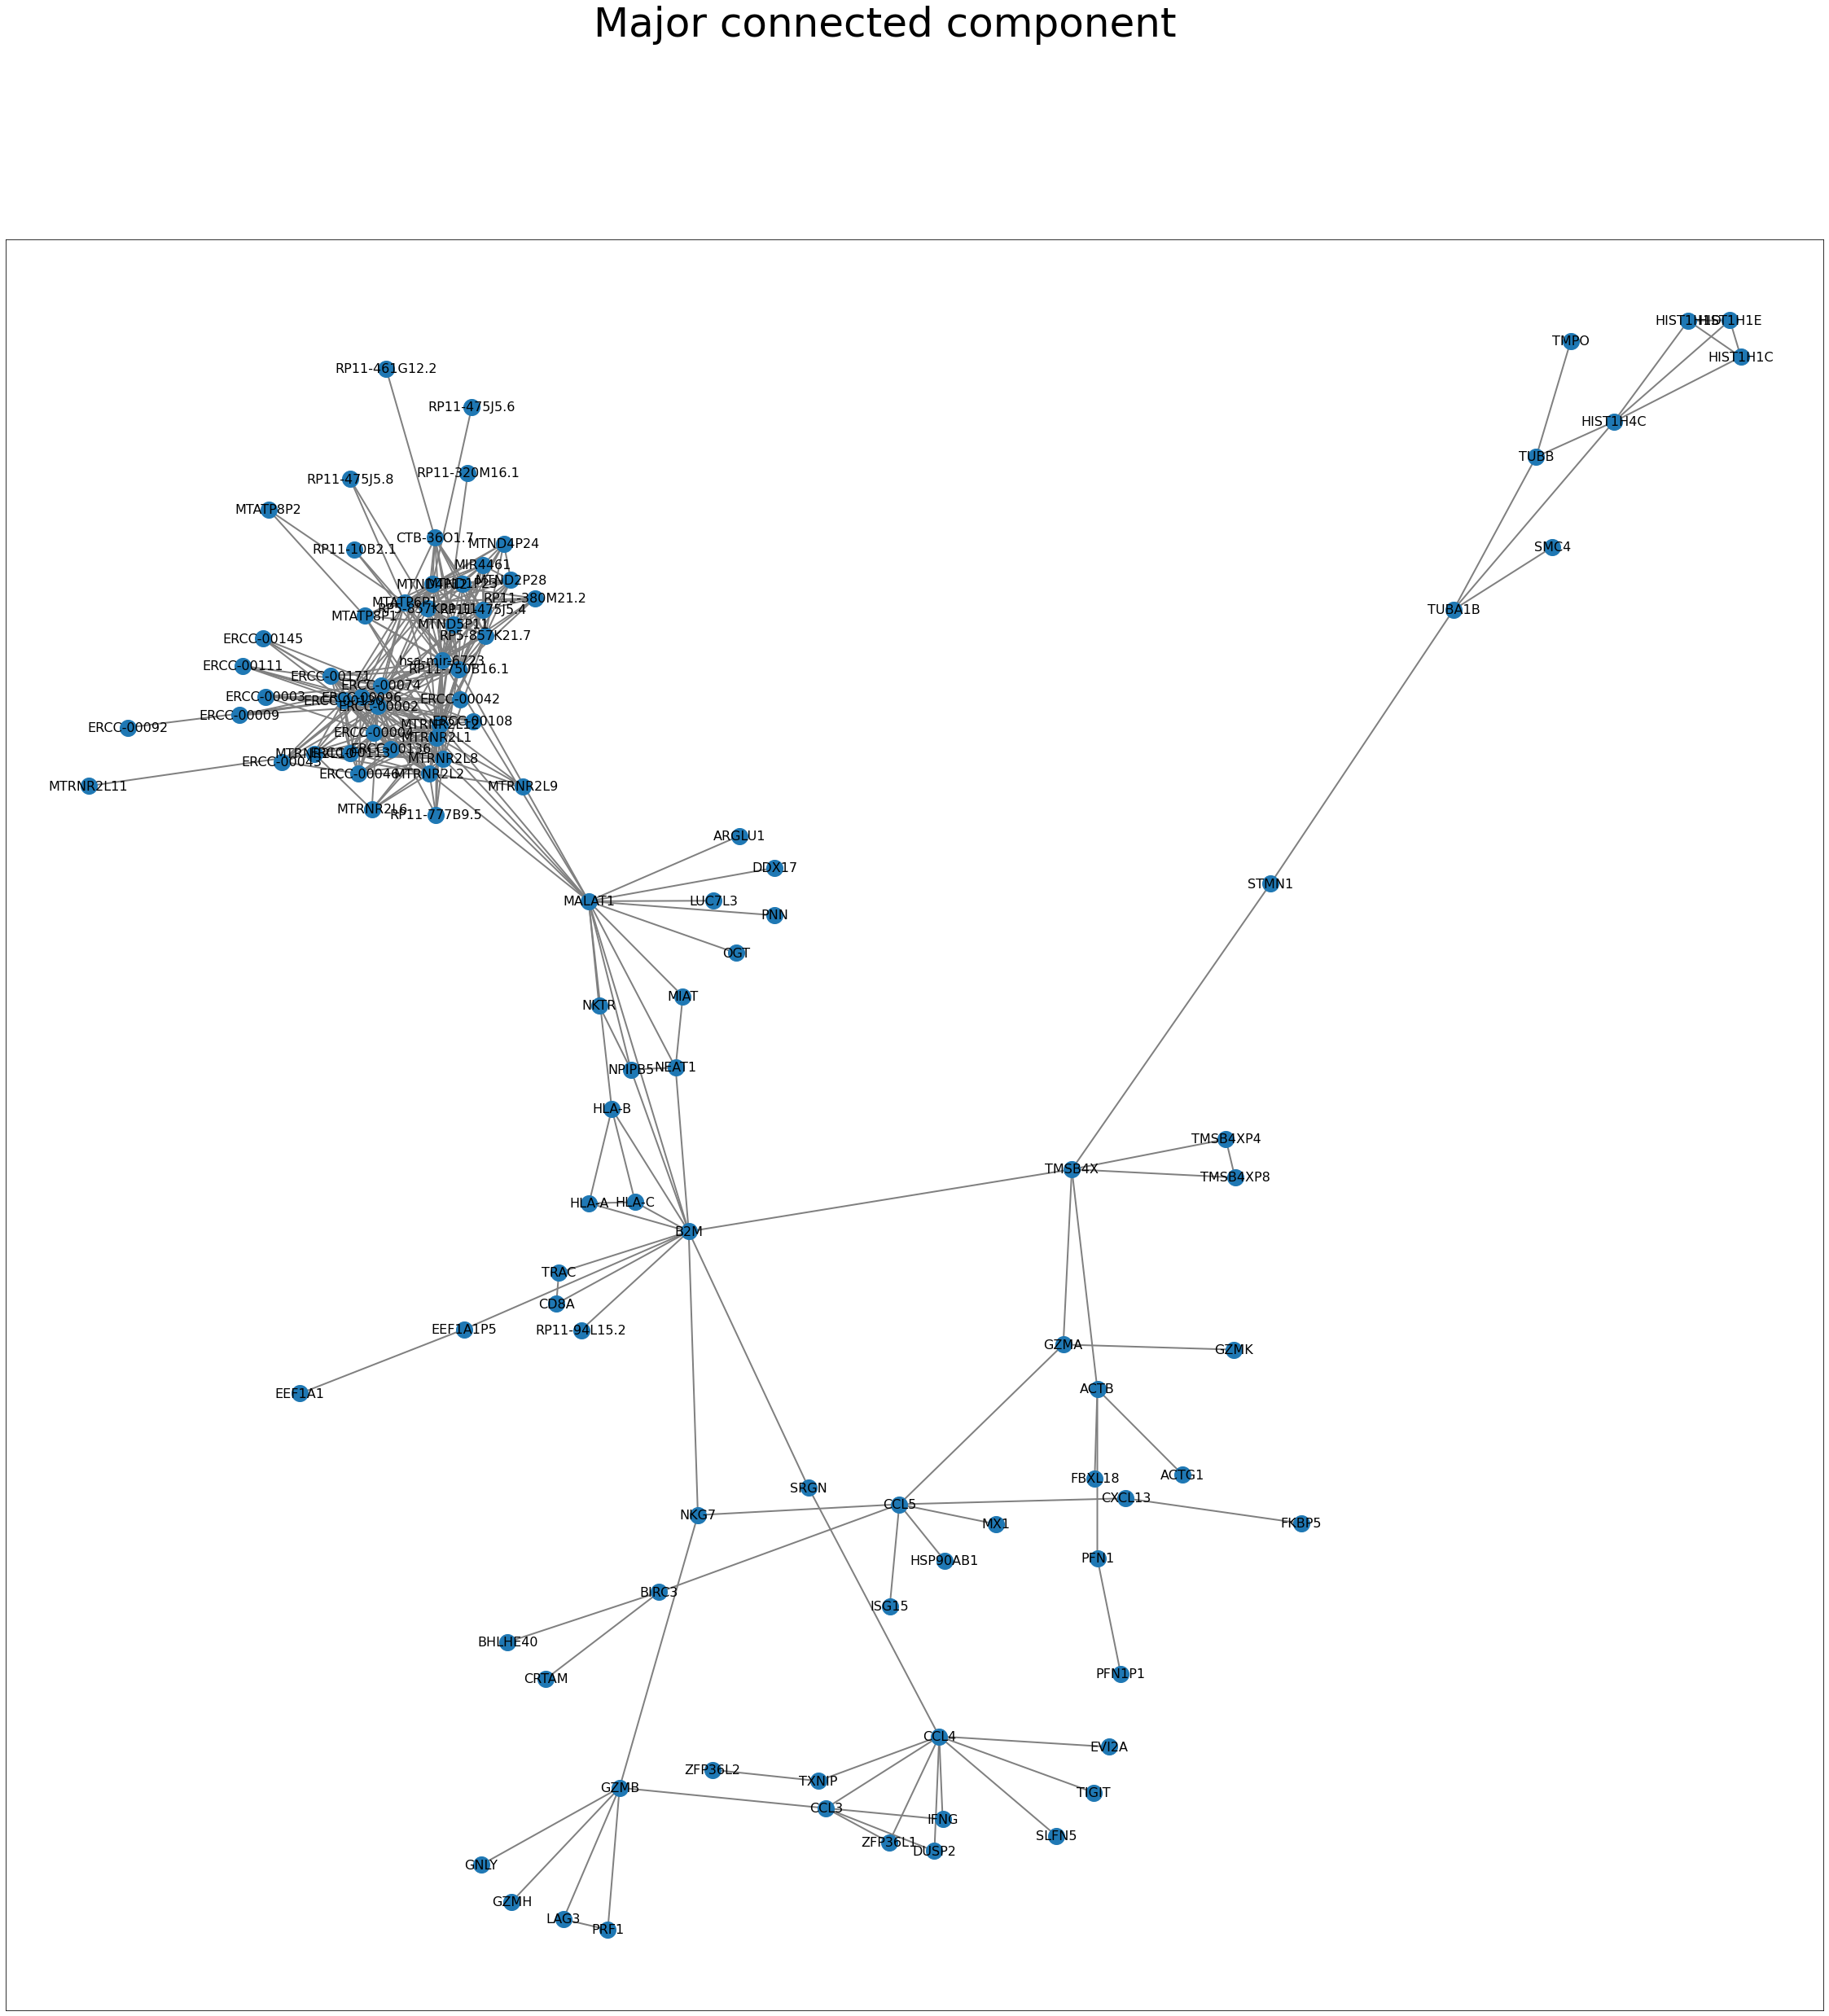

Co-expression with 4 GO covariates removed.
Number of nodes in full network: 396
Number of edges in full network: 581
Number of nodes in major connected component: 62
Number of edges in major connected component: 84


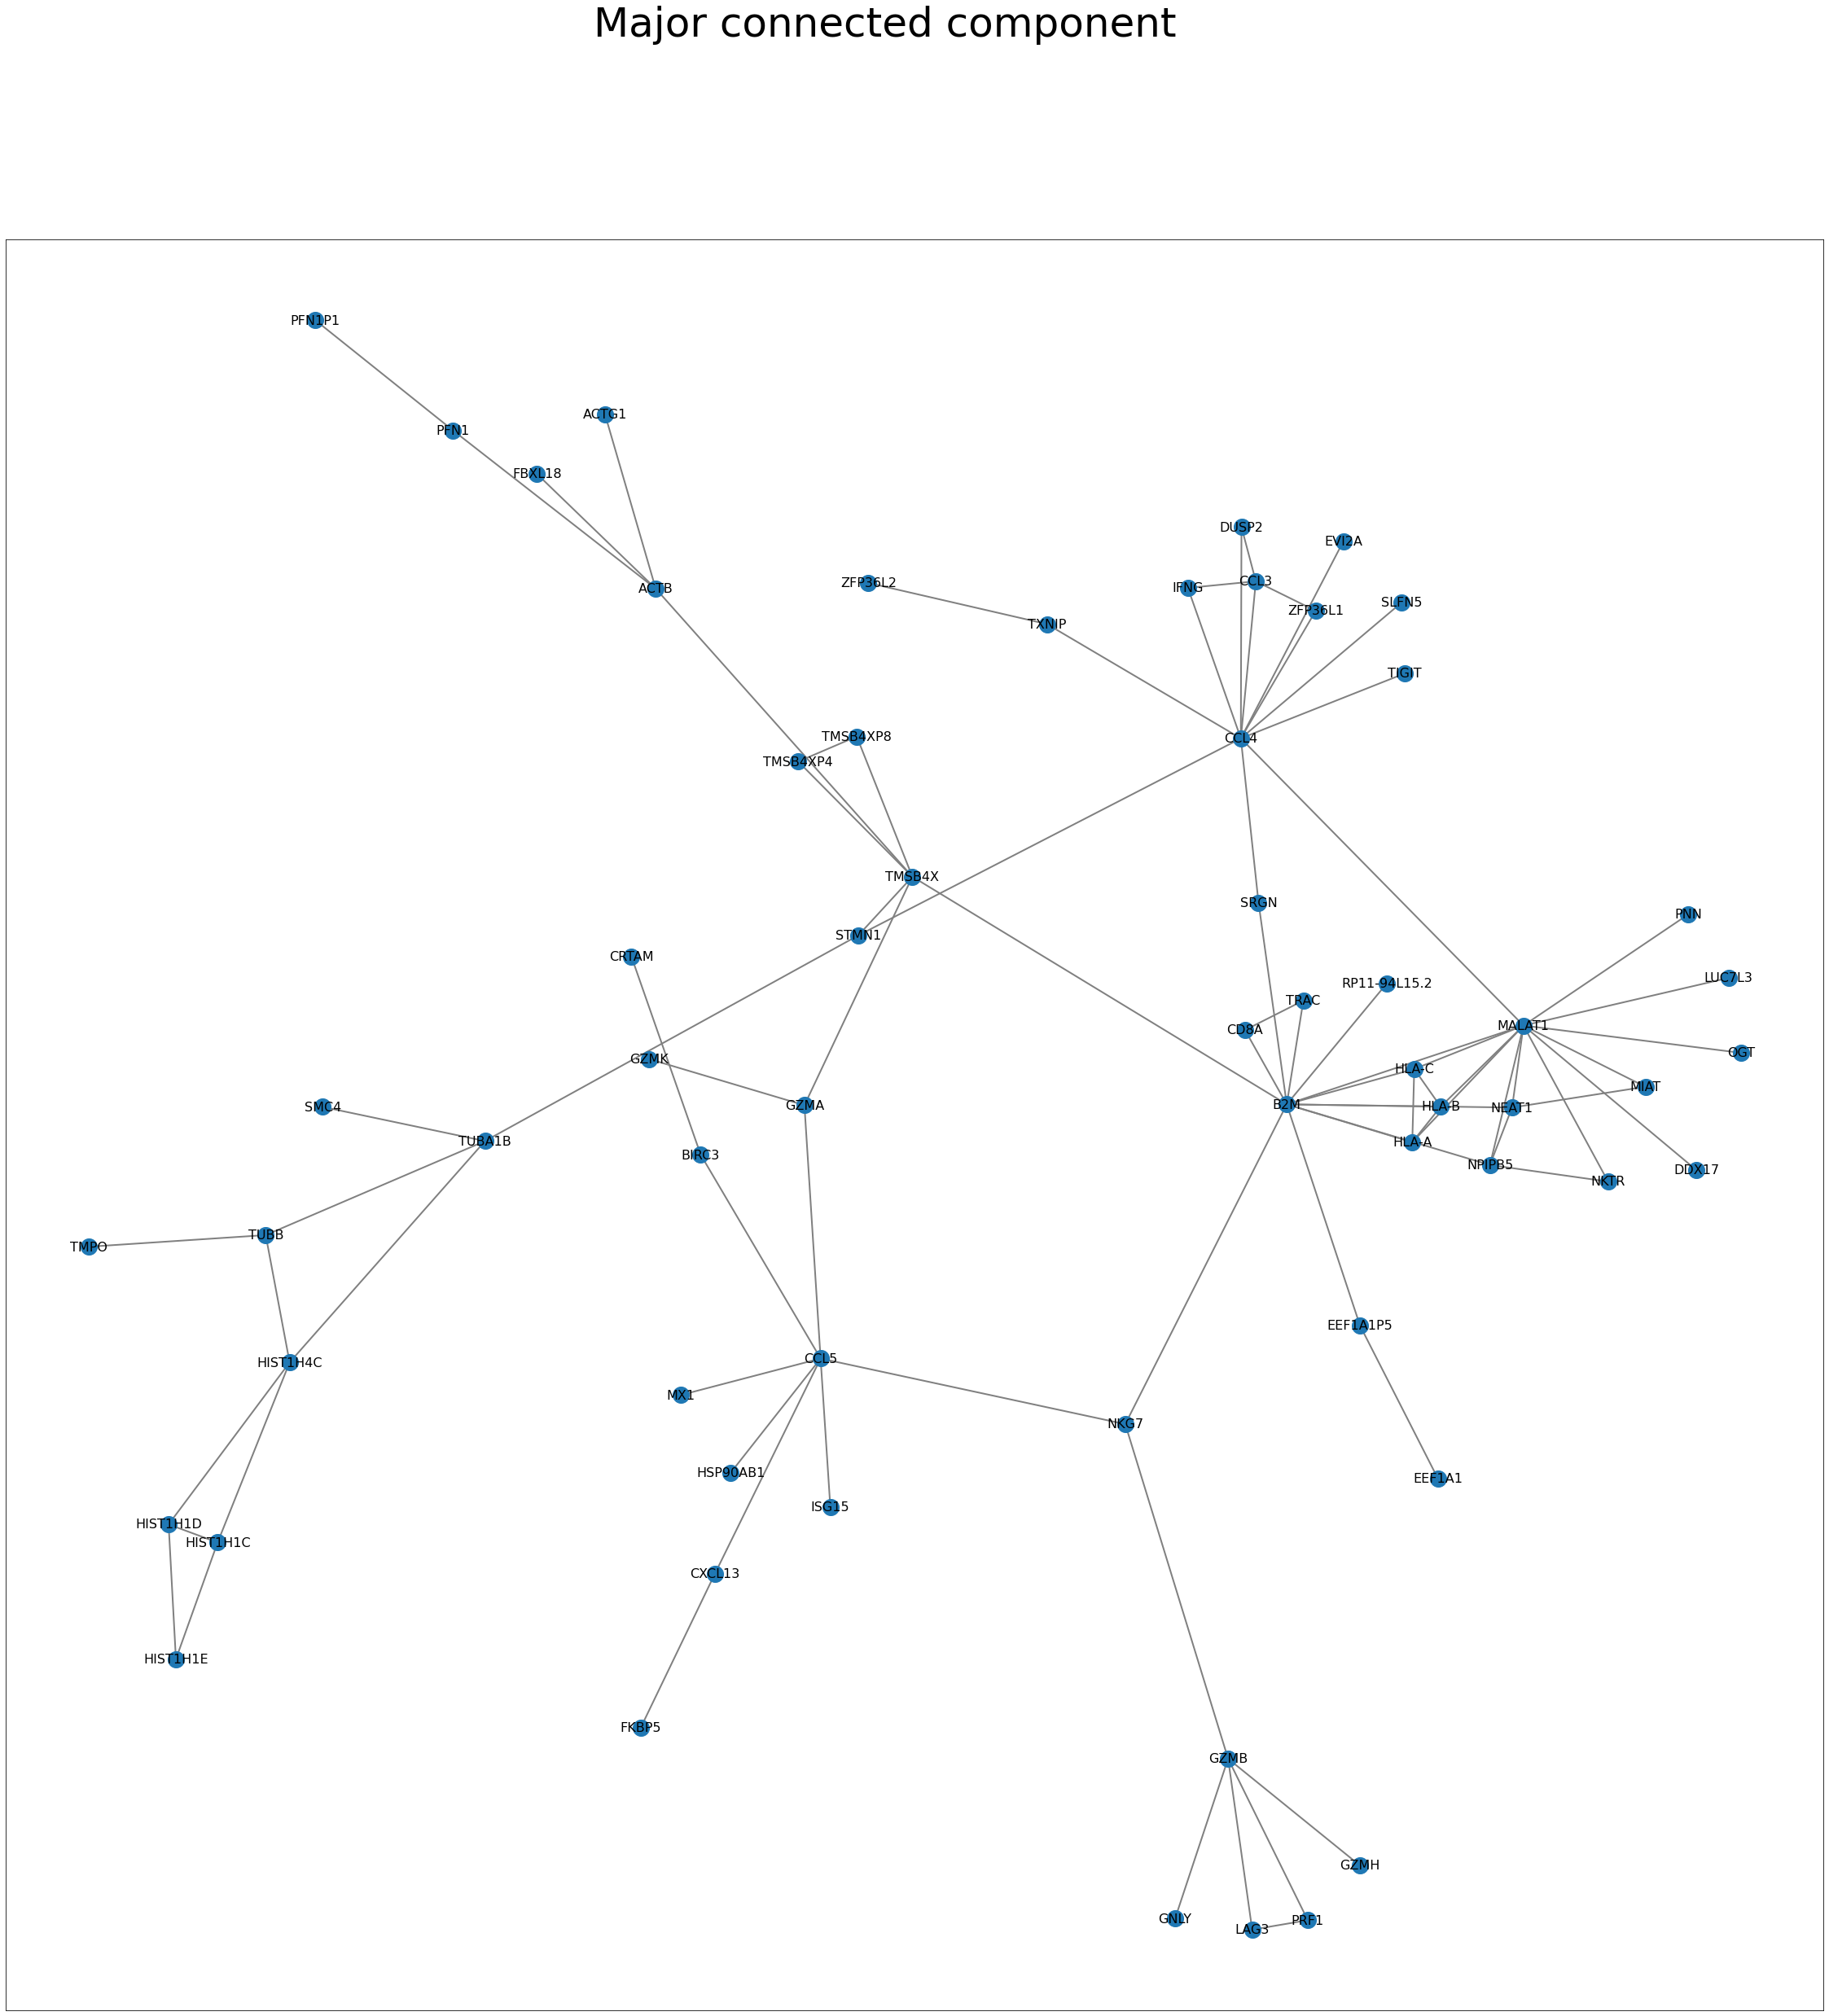

Co-expression with 5 GO covariates removed.
Number of nodes in full network: 396
Number of edges in full network: 575
Number of nodes in major connected component: 62
Number of edges in major connected component: 84


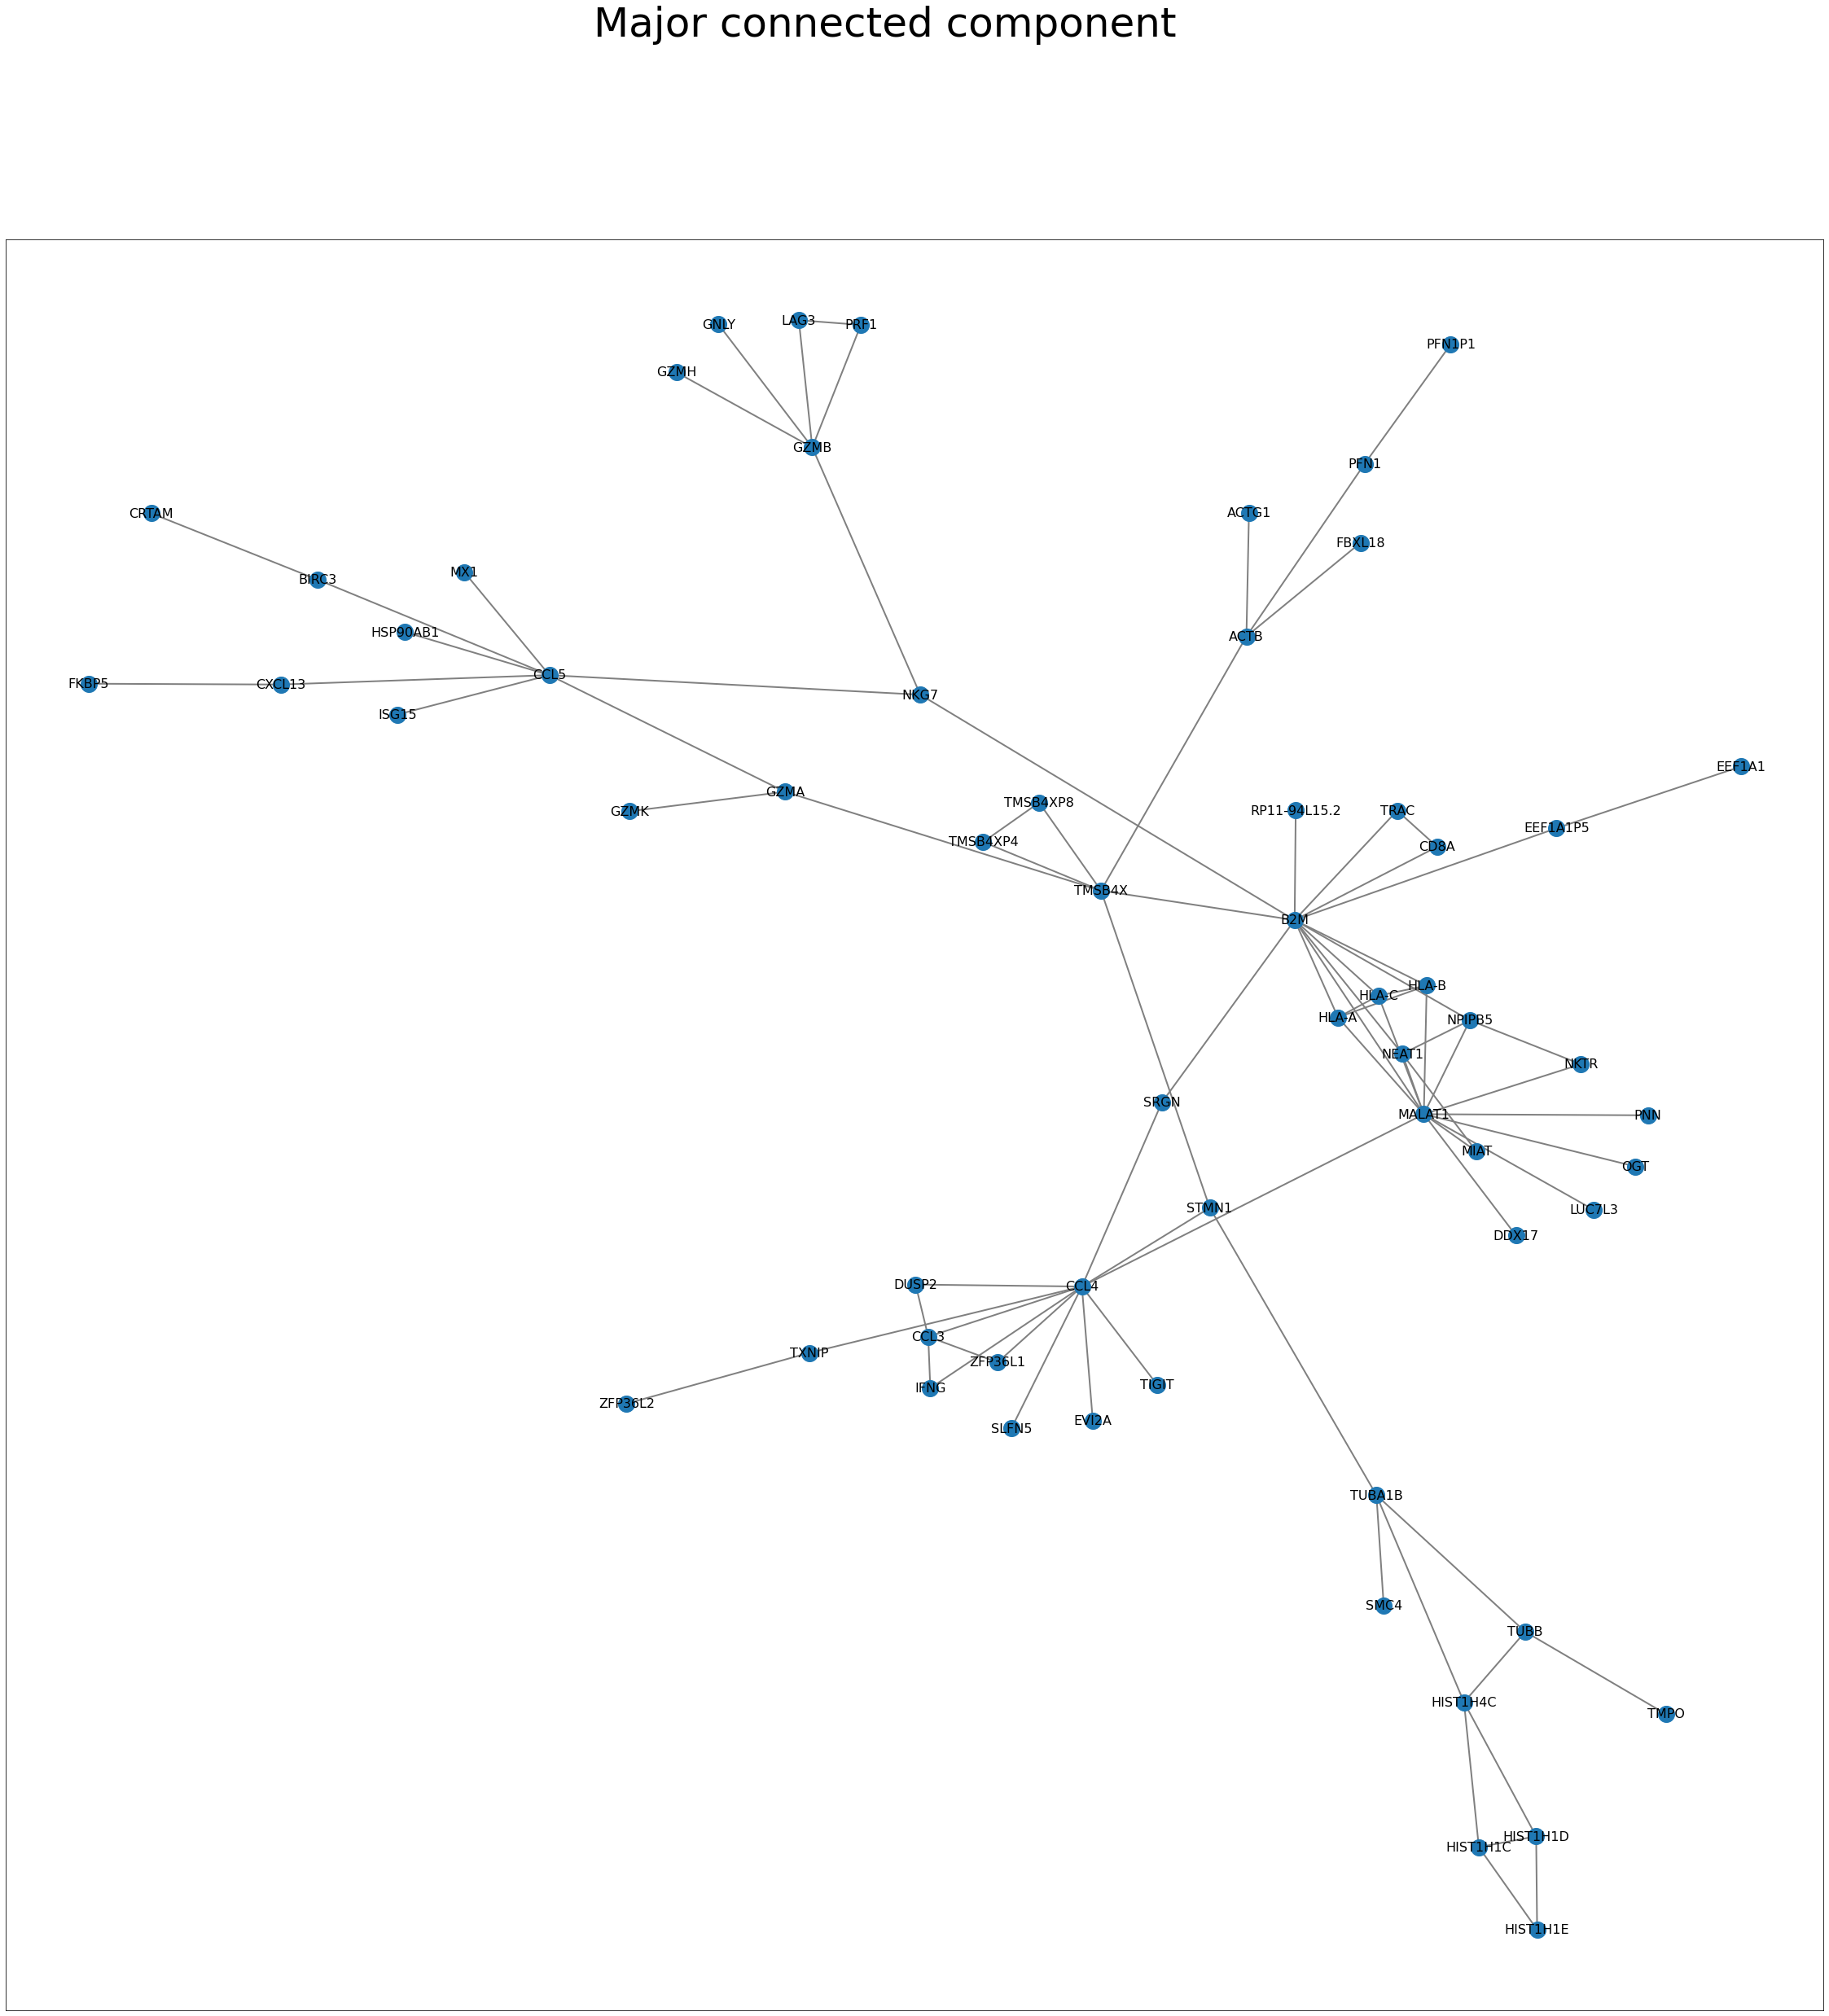

In [15]:
figscale=2
tdict=dict(zip(namet,range(len(namet))))
for xi in range(lvmax+1):
	print('Co-expression with {} GO covariates removed.'.format(xi))
	net=coex[xi][1]
	net|=net.T
	t1=net.any(axis=1)>0
	net=net[t1][:,t1]
	tnet=namet[t1]
	print('Number of nodes in full network: {}'.format(net.shape[0]))
	print('Number of edges in full network: {}'.format(net.sum()//2))
	#To major connected component
	t1=np.zeros_like(net)
	net2=net.copy()
	while (t1!=net2).any():
		t1=net2.copy()
		net2|=np.matmul(net2,net2)
	t1=net2.sum(axis=0)
	t1=t1==t1.max()
	net=net[t1][:,t1]
	tnet=tnet[t1]
	print('Number of nodes in major connected component: {}'.format(net.shape[0]))
	print('Number of edges in major connected component: {}'.format(net.sum()//2))
	#Draw here
	net2=pd.DataFrame(net,index=tnet,columns=tnet)
	net3=nx.to_networkx_graph(net2)
	f=plt.figure(figsize=(20*figscale,20*figscale))
	nx.draw_networkx(net3,node_size=200*figscale,font_size=8*figscale,width=1*figscale,edge_color=[0.5]*3);
	f.suptitle('Major connected component',fontsize=25*figscale);
	plt.show()
	#You can also output the network and draw it in Cytoscape